In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model
import impl.layer as l

class LSTM:
    
    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters wights and biases
        Z = H + D
        m = dict(
            Wf=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wi=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wc=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wo=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bf=np.zeros((1, H)),
            bi=np.zeros((1, H)),
            bc=np.zeros((1, H)),
            bo=np.zeros((1, H)),
            by=np.zeros((1, D)))

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return (np.zeros((1, self.H)), np.zeros((1, self.H)))

    def forward(self, X, h, m):
        Wf, Wi, Wc, Wo, Wy = m['Wf'], m['Wi'], m['Wc'], m['Wo'], m['Wy']
        bf, bi, bc, bo, by = m['bf'], m['bi'], m['bc'], m['bo'], m['by']

        h_in, c_in = h
        X_in = X.copy()

        X = np.column_stack((h_in, X_in))

        hf, hf_cache = l.fc_forward(X, Wf, bf)
        hf, hf_sigm_cache = l.sigmoid_forward(hf)

        hi, hi_cache = l.fc_forward(X, Wi, bi)
        hi, hi_sigm_cache = l.sigmoid_forward(hi)

        hc, hc_cache = l.fc_forward(X, Wc, bc)
        hc, hc_tanh_cache = l.tanh_forward(hc)

        c = (hf * c_in) + (hi * hc)
        c, c_tanh_cache = l.tanh_forward(c)

        ho, ho_cache = l.fc_forward(X, Wo, bo)
        ho, ho_sigm_cache = l.sigmoid_forward(ho)

        h = ho * c
        
        h_ = (h, c)
        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (c_in, hf, hf_cache, hf_sigm_cache, hi, hi_cache, hi_sigm_cache, hc, hc_cache, hc_tanh_cache, c, c_tanh_cache, ho, ho_cache, ho_sigm_cache, y_cache)
        
        return y, h_, cache

    def backward(self, dy, dh, cache):
        c_in, hf, hf_cache, hf_sigm_cache, hi, hi_cache, hi_sigm_cache, hc, hc_cache, hc_tanh_cache, c, c_tanh_cache, ho, ho_cache, ho_sigm_cache, y_cache = cache

        dh_out, dc_out = dh

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dho = c * dh
        dho = l.sigmoid_backward(dho, ho_sigm_cache)
        dXo, dWo, dbo = l.fc_backward(dho, ho_cache)

        dc = ho * dh
        dc = l.tanh_backward(dc, c_tanh_cache)
        dc += dc_out
        dc_in = hf * dc

        dhf = c_in * dc
        dhf = l.sigmoid_backward(dhf, hf_sigm_cache)
        dXf, dWf, dbf = l.fc_backward(dhf, hf_cache)

        dhi = hc * dc
        dhi = l.sigmoid_backward(dhi, hi_sigm_cache)
        dXi, dWi, dbi = l.fc_backward(dhi, hi_cache)

        dhc = hi * dc
        dhc = l.tanh_backward(dhc, hc_tanh_cache)
        dXc, dWc, dbc = l.fc_backward(dhc, hc_cache)

        dX = dXo + dXc + dXi + dXf
        dh_in = dX[:, :self.H]
        dX_in = dX[:, self.H:]
        
        dh = (dh_in, dc_in)
        dX = dX_in

        grad = dict(Wf=dWf, Wi=dWi, Wc=dWc, Wo=dWo, Wy=dWy, bf=dbf, bi=dbi, bc=dbc, bo=dbo, by=dby)

        return dX, dh, grad
            
    def train_forward(self, X_train, h_):
        ys, caches = [], []
        #         h_init = h.copy()
        h, c = h_
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append((np.zeros((1, self.H)), np.zeros((1, self.H))))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h_, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        #         h_init = h.copy()
        h, c = h_
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    eps = 1e-8 # const epsillon
    smooth_loss = 1
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Updating the model parameters
            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items, dict={}
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
                
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100) # time_step=mb_size
            print(sample)
    
    return nn

Iter-10 loss: 36.1206
can and i4ay as renrluthoed eoxdornd 193n inesn oprmsd aniesnl CChn efpr-wpepmp py ipitotan panse 99B
Iter-20 loss: 35.9957
c ane'igur, 1Nikhe xphorpmpa'Cheerd the Hhereor Soryer' orlaJaosteyyicenat ol thesoatecienc-oNparaoar
Iter-30 loss: 35.7361
coupantappCbes eikalyrphe WE3aordera,o, ofokuprri, obr is iin mphe AamalrPheorceapapsad opalofolbbis 
Iter-40 loss: 35.5218
caipe Joomr ehm,rGhasoraukhdeurmermero Japaponatestiriigereuwermpdasre bompeapaxopupehhieuulamPalaalh
Iter-50 loss: 35.2915
c and any m0R. R9L8al mitheoHare'edheheerapaaoapireo'uushe.hr3f, abhe Taporlherrighiuthhe.,ri8j'erthe
Iter-60 loss: 35.1323
c9Hal Krmho biplesuuKheicheanaapherouShhijhoubhthhiophh8hsu1,h8NiG414xlphhesomeamho日4
Chieapari. oHof
Iter-70 loss: 35.0055
cion The AaparoiLh,chghkeuWubamfeapmaomphlhiphemhhoreuchi4.h iunmh1647"ithithichs8ghsishmiauslhighlhi
Iter-80 loss: 34.7831
ch omuthe phheutAaJaapaacacafathrisiu,ydespapeapuphehaeepphosmShshueh7m4"u8FhhhhoImemareh0gheomaaania
Iter-90 

Iter-670 loss: 4.4080
cat coniten inddunwang N2Jppirueeiiiusic toryldyg tataiisdddsag it in firnn dg sggasld rheee anito in
Iter-680 loss: 4.0219
cs. Japan is geccerinimSiJaasunee i2llllle on ofroD ousokupopfofoni1mBt is tobonllly 9hhhhss Sobu ss 
Iter-690 loss: 3.9748
ced coutitaid ga tal was m. thhh Jauiasiion,opmparoshuntnocdepan iisisusuvokky-,iiomat. Sulolky.ihiia
Iter-700 loss: 4.0466
ch cingects atose ipiriniinintr. bhiciicmiite mpipaeith heriathiciaciat lapad. Saaaseeipare annde ann
Iter-710 loss: 3.9211
capital wi "eeeciciachhimr l.erane indeinto rinnJaurwaaeis-Ri,, th chimiathitiini a-olepaissauntel cg
Iter-720 loss: 4.0567
ctetily wes 8ereh.utere-torly afe laleviaes,sgang son aeeoay tPmi2本 Jpand inssssEEpnnd mey in yteppas
Iter-730 loss: 3.6302
con. kho ole'tity momeitiarge searare easaeddllinn;n thistesl. 1s8iuChiat hes heithiGt. Japan i nd an
Iter-740 loss: 3.6355
c Games.
. lalaly's, nr,, tarnlsskht in orhiss-uo-outi-tihiiiicmp mouru. n lopwreiiasmhisuragosk. ira
Iter-750

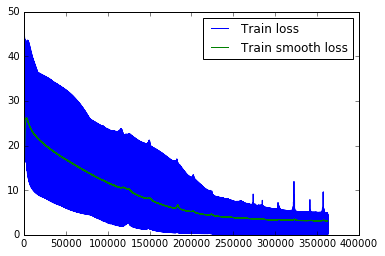

In [4]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = LSTM(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()